**Imports**

In [1]:
%matplotlib inline

# Conda imports
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib.ticker import PercentFormatter
from scipy.linalg import subspace_angles
from scipy.stats.stats import pearsonr

# Local imports
import common
import helpers
import processing.statistics as statistics
from data import get_mnist, get_cifar
from experiment import Experiment
from processing.snapshots import Snapshots

## Loading a model

In [2]:
def results_path(output_dir, layers):
    fp_paths ={}
    ip_paths = {}
    norms_paths = {}
    for layer in layers:
        fp_paths[layer] = helpers.train_results_path(output_dir, common.FP_PREFIX, layer)
        ip_paths[layer] = helpers.train_results_path(output_dir, common.IP_PREFIX, layer)
        norms_paths[layer] = helpers.train_results_path(output_dir, common.NORM_PREFIX, layer)
        
    return fp_paths, ip_paths, norms_paths

In [3]:
conv2_output = "out/Conv2-28_11_2019-10:21:39"
conv4_output = "out/Conv4-28_11_2019-18:17:15"
conv6_output = "out/Conv6-28_11_2019-18:23:42"

output_dir = conv2_output  # changeme
layers = ["conv1", "fc1", "fc2"]
fp_paths, ip_paths, norms_paths = results_path(output_dir, layers)

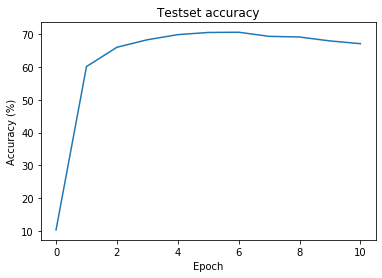

In [4]:
helpers.plot_test_acc(output_dir)

In [5]:
acc_path = os.path.join(output_dir, common.METRICS_DIR, common.TRAINING_DIR, common.ACCURACY_FNAME)
test_accuracies = np.load(acc_path)
print("Best test accuracy at epoch N°", np.argmax(test_accuracies))

Best test accuracy at epoch N° 6


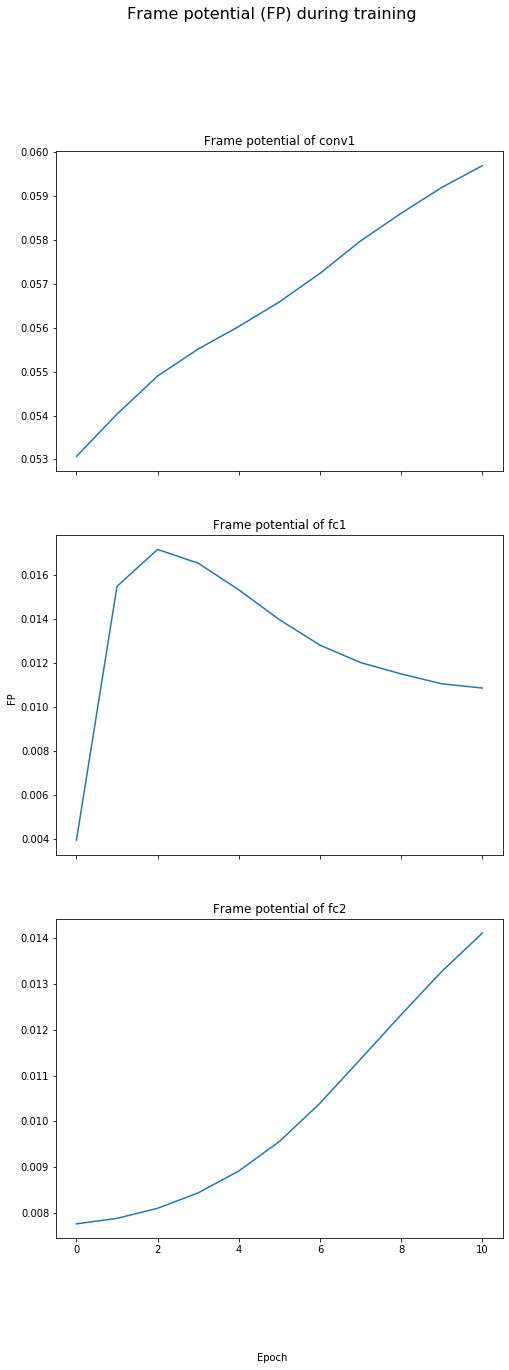

In [6]:
helpers.plot_train_fps(fp_paths, layers)

## Analysis of a layer

In [7]:
# Because of overfitting, we might want restrict the analysis to the first n epochs
epochs = np.argmax(test_accuracies) + 1
layer = "fc1"
weight_norms = np.load(norms_paths[layer])[:epochs]
s = Snapshots(output_dir)
weights = s.get_weights(layer)[:epochs]

### 1. Plot of L2-norm distribution

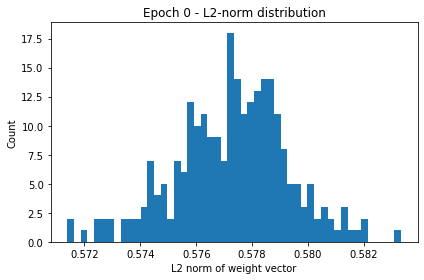

In [8]:
def norm_distribution(norms, epoch):
    fig, ax = plt.subplots(tight_layout=True)
    ax.hist(norms[epoch], bins=50)
    ax.set_xlabel("L2 norm of weight vector")
    ax.set_ylabel("Count")
    ax.set_title(f"Epoch {epoch} - L2-norm distribution")
    plt.show()
    
norm_distribution(weight_norms, 0)

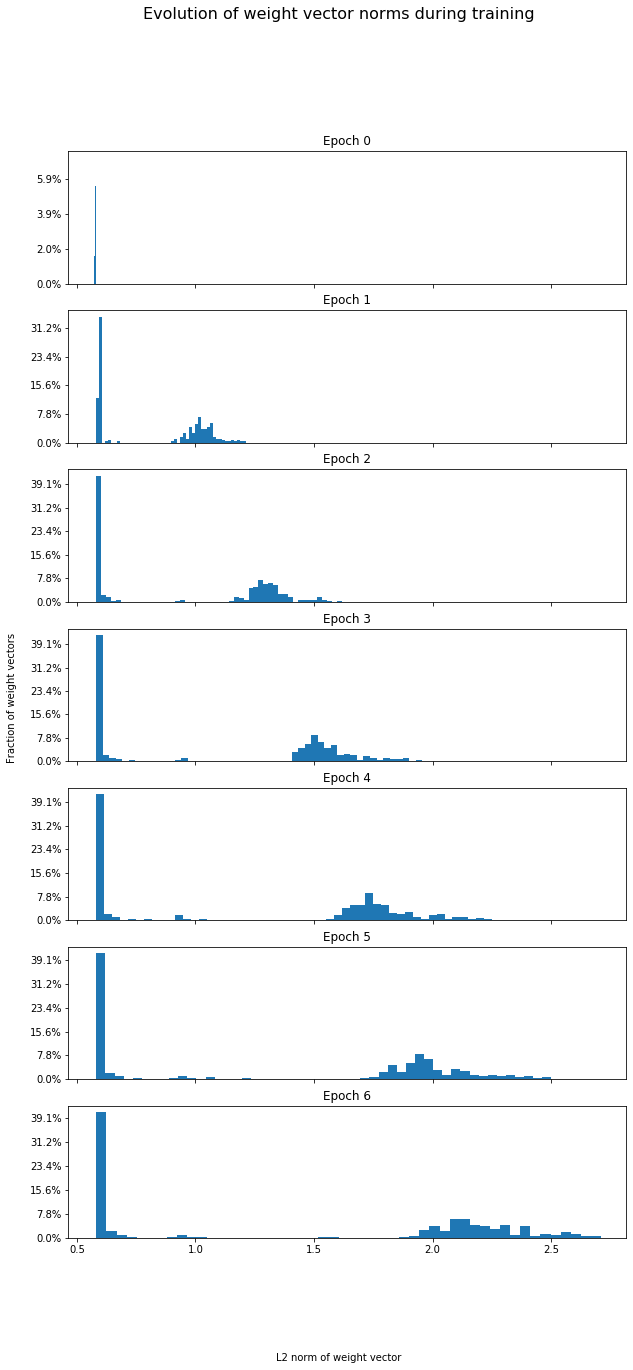

In [9]:
def plot_training_norms(norms):
    epochs = norms.shape[0]
    fig, axs = plt.subplots(epochs, 1, figsize=(10, 20), sharex=True)

    for epoch in range(norms.shape[0]):
        axs[epoch].hist(norms[epoch], bins=50)
        axs[epoch].yaxis.set_major_formatter(PercentFormatter(xmax=norms.shape[1]))
        axs[epoch].set_title(f"Epoch {epoch}")

    fig.suptitle("Evolution of weight vector norms during training", fontsize=16)
    fig.text(0.5, 0.04, 'L2 norm of weight vector', ha='center')
    fig.text(0.04, 0.5, 'Fraction of weight vectors', va='center', rotation='vertical')

    plt.show()
    
plot_training_norms(weight_norms)

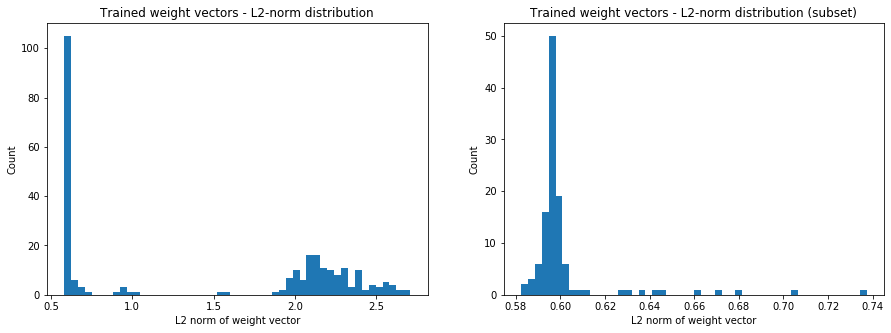

In [10]:
def trained_vector_norms(norms, cut_off=0.8):
    final_norms = norms[-1]
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    hist = axs[0].hist(final_norms, bins=50)
    axs[0].set_xlabel("L2 norm of weight vector")
    axs[0].set_ylabel("Count")
    axs[0].set_title("Trained weight vectors - L2-norm distribution")
    selected_norms = final_norms[final_norms < cut_off]
    hist = axs[1].hist(selected_norms, bins=50)
    axs[1].set_xlabel("L2 norm of weight vector")
    axs[1].set_ylabel("Count")
    axs[1].set_title("Trained weight vectors - L2-norm distribution (subset)")
    plt.show()
    
trained_vector_norms(weight_norms)

### 2. Analysis of space spanned by normalized weight vectors

In [11]:
w = torch.zeros(weights.shape)
# Normalize the weight vectors for every epoch
for epoch in range(epochs):
    w[epoch] = F.normalize(weights[epoch], p=2, dim=1)

In [12]:
def svd(selected_weights):
    epochs, n_params, param_length = selected_weights.shape
    k = min(n_params, param_length)
    u = np.zeros((epochs, param_length, k))
    s = np.zeros((epochs, k))
    vh = np.zeros((epochs, k, n_params))

    for epoch in range(epochs):
        # Look at space spanned by the rows of the weight matrix
        w_epoch = selected_weights[epoch].numpy().T
        u_epoch, s_epoch, vh_epoch = np.linalg.svd(w_epoch, full_matrices=False)
        u[epoch] = u_epoch
        s[epoch] = s_epoch
        vh[epoch] = vh_epoch
    
    return u, s, vh

In [13]:
def singular_value_distribution(s):
    epochs = s.shape[0]
    fig, axs = plt.subplots(epochs, 1, figsize=(10, 20), sharex=True)

    for epoch in range(epochs):
        axs[epoch].hist(s[epoch], bins=50)
        axs[epoch].yaxis.set_major_formatter(PercentFormatter(xmax=s.shape[1]))
        axs[epoch].set_title(f"Epoch {epoch}")

    fig.suptitle("Evolution of singular values during training", fontsize=16)
    fig.text(0.5, 0.04, 'Value', ha='center')
    fig.text(0.04, 0.5, 'Fraction of singular values', va='center', rotation='vertical')

    plt.show()

In [14]:
def svd_comparison(s):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    hist = axs[0].hist(s[0], bins=20)
    axs[0].set_xlabel("Value")
    axs[0].set_ylabel("Count")
    axs[0].set_title("Singular values distribution of untrained weight matrix")
    hist = axs[1].hist(s[-1], bins=20)
    axs[1].set_xlabel("Value")
    axs[1].set_ylabel("Count")
    axs[1].set_title("Singular values distribution of trained weight matrix")
    plt.show()

In [15]:
u_full, s_full, vh_full = svd(w)

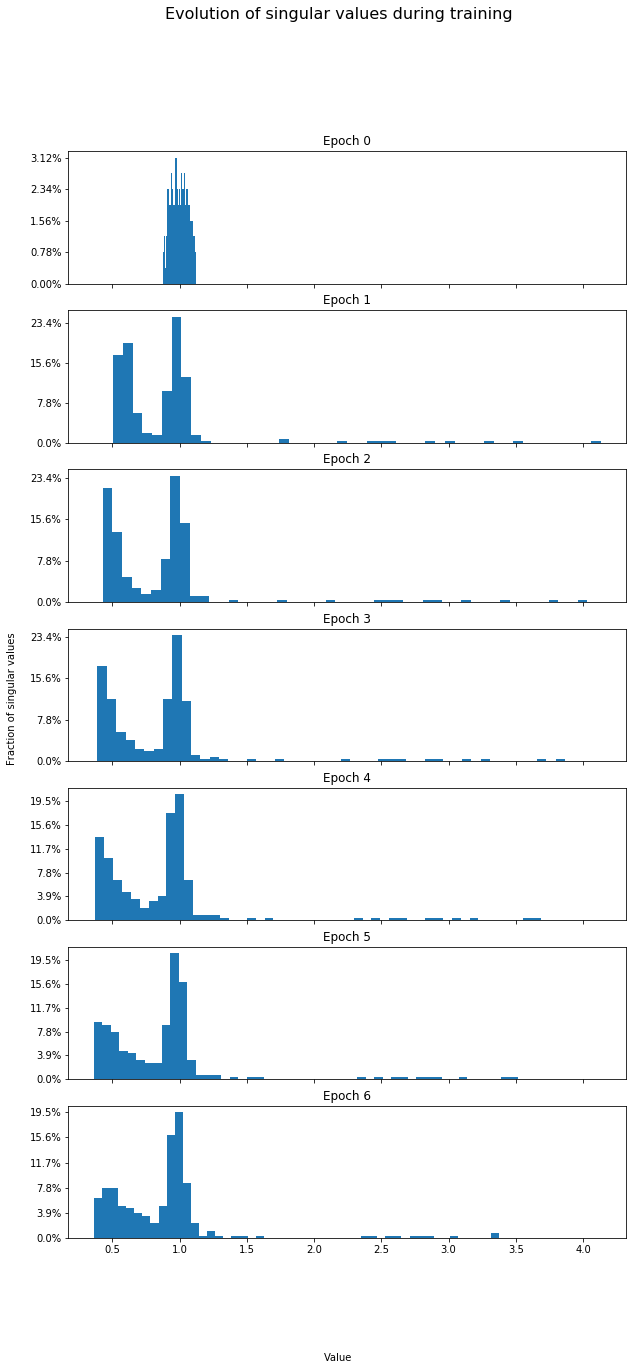

In [16]:
singular_value_distribution(s_full)

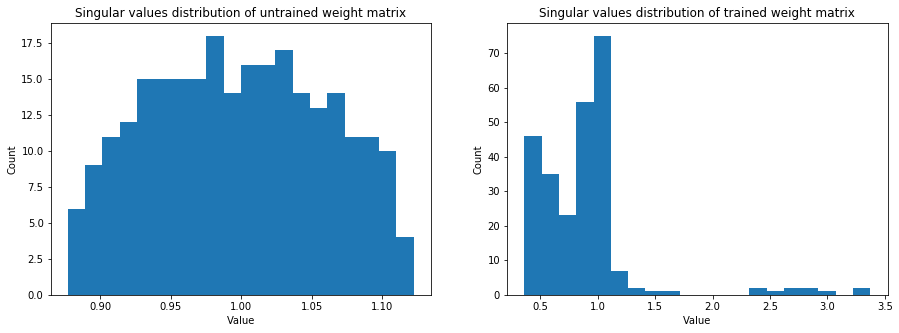

In [17]:
svd_comparison(s_full)

### 3. Looking at selected weight vectors

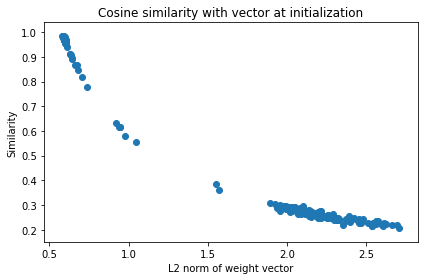

In [18]:
def plot_trained_similarity(weights, norms):
    fig, ax = plt.subplots(tight_layout=True)
    start = weights[0].numpy().T
    end = weights[-1].numpy().T
    similarity = np.diag(start.T @ end)
    ax.scatter(norms[-1], similarity)
    ax.set_xlabel("L2 norm of weight vector")
    ax.set_ylabel("Similarity")
    ax.set_title("Cosine similarity with vector at initialization")
    plt.show()
    
plot_trained_similarity(w, weight_norms)

In [19]:
cutoff = 0.9
trained_neurons = (weight_norms[-1] > cutoff)
selected_neurons = np.argwhere(trained_neurons).flatten().tolist()
unselected_neurons = np.argwhere(~trained_neurons).flatten().tolist()

In [20]:
u_selected, s_selected, vh_selected = svd(w[:, selected_neurons, :])

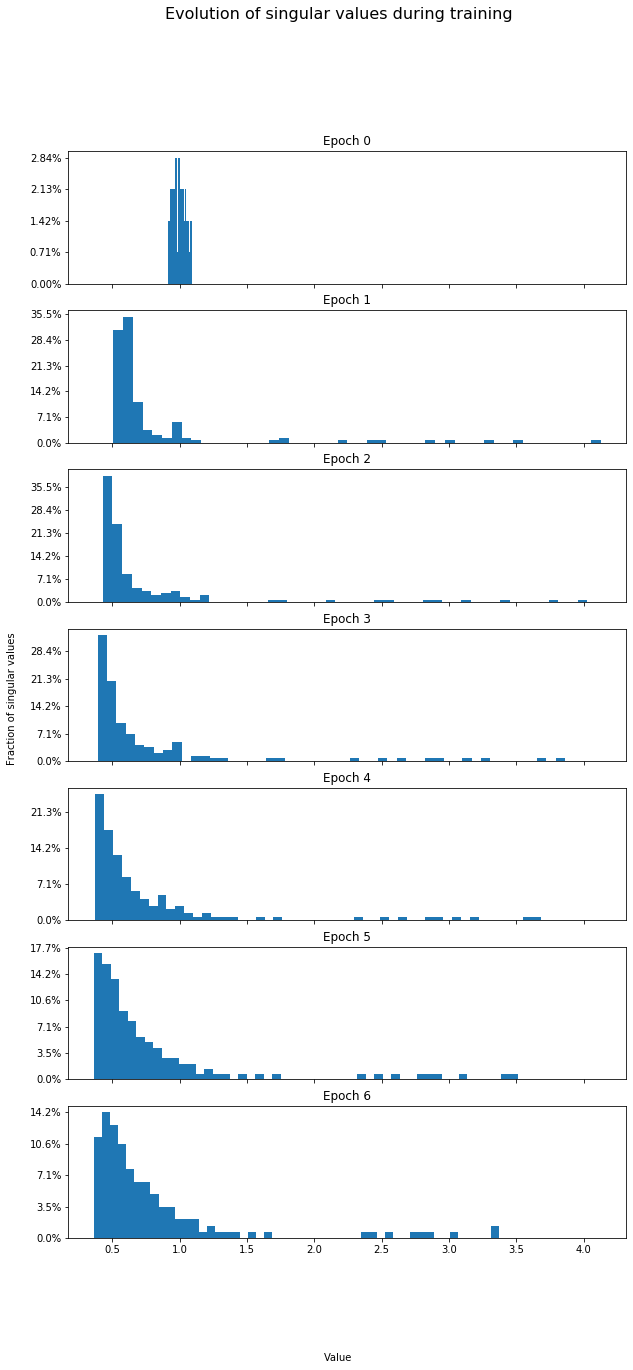

In [21]:
singular_value_distribution(s_selected)

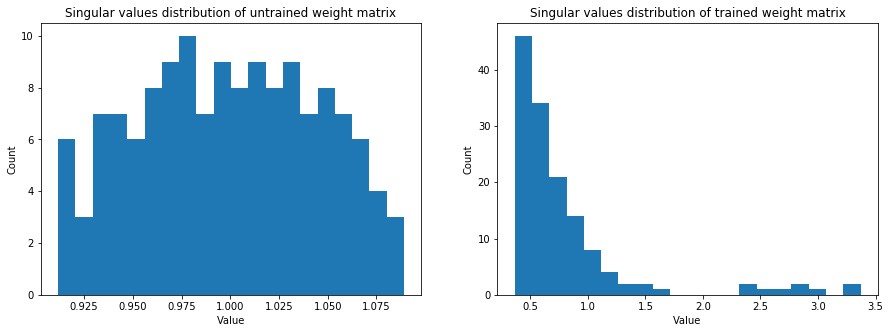

In [22]:
svd_comparison(s_selected)

### 4. Looking at unselected weight vectors

In [23]:
u_unselected, s_unselected, vh_unselected = svd(w[:, unselected_neurons, :])

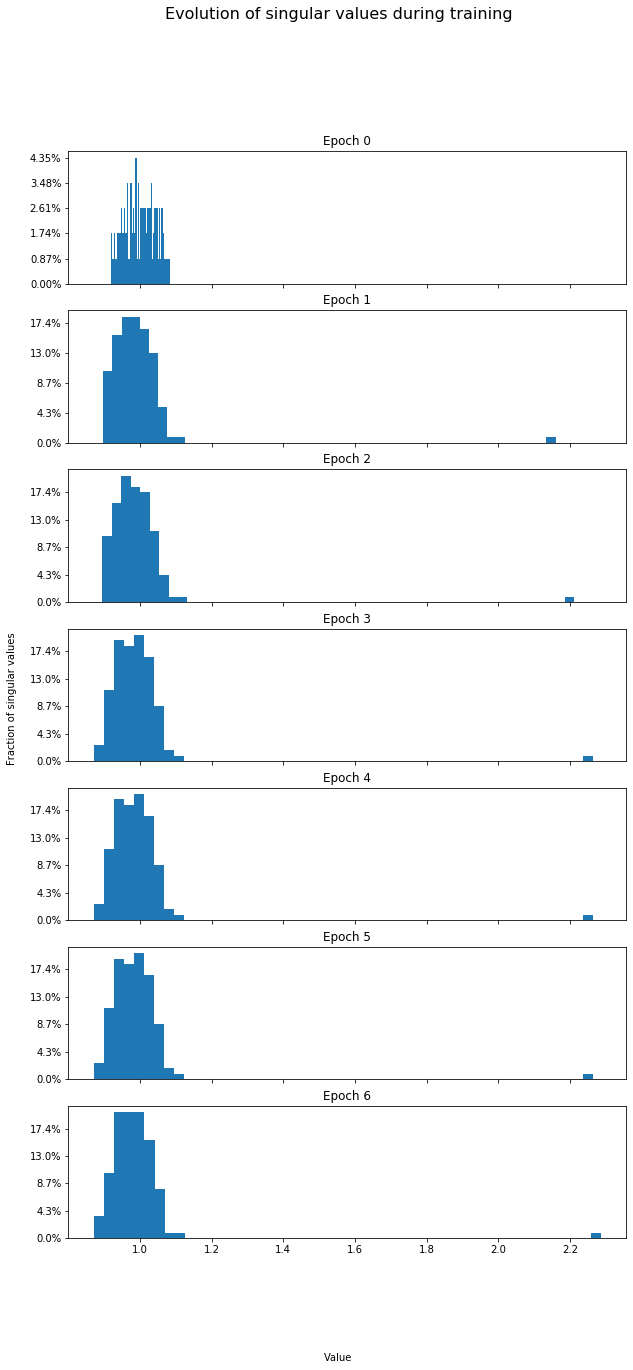

In [24]:
singular_value_distribution(s_unselected)

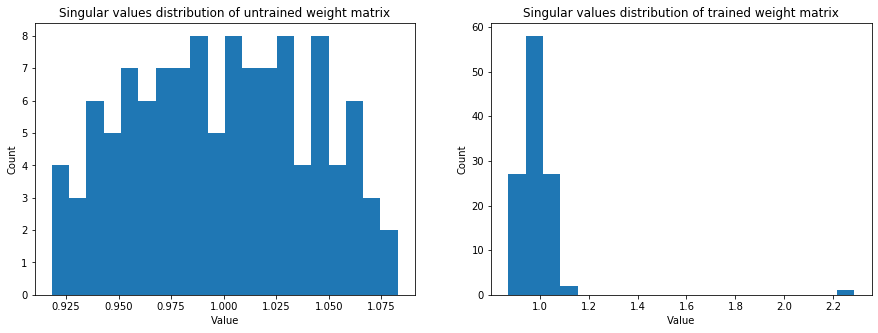

In [25]:
svd_comparison(s_unselected)

### 5. Comparing selected and unselected weight vectors

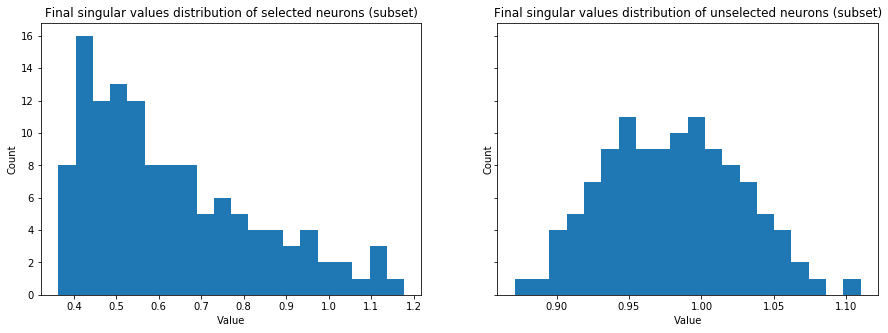

In [26]:
def selection_comparison(s1, s2):
    final_svs = s1[-1]
    s_filtered = final_svs[final_svs < 1.2]
    fig, axs = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
    hist = axs[0].hist(s_filtered, bins=20)
    axs[0].set_xlabel("Value")
    axs[0].set_ylabel("Count")
    axs[0].set_title("Final singular values distribution of selected neurons (subset)")
    final_svs = s2[-1]
    s_filtered = final_svs[final_svs < 1.2]
    hist = axs[1].hist(s_filtered, bins=20)
    axs[1].set_xlabel("Value")
    axs[1].set_ylabel("Count")
    axs[1].set_title("Final singular values distribution of unselected neurons (subset)")
    plt.show()
    
selection_comparison(s_selected, s_unselected)

### 6. Low-rank approximation

In [27]:
def plot_reconstruction_error(s, num_classes=10):
    epochs = s.shape[0]
    squared_s = s**2
    fig, axs = plt.subplots(epochs, 2, figsize=(14, 20), sharex=True)

    for epoch in range(epochs):
        s_epoch = squared_s[epoch]
        res = np.array([s_epoch[i:].sum() for i in range(s_epoch.size+1)])
        diff = res[1:] - res[:-1]
        axs[epoch][0].plot(res)
        axs[epoch][0].axvline(num_classes+1, color='red', linestyle='-.', linewidth=1.0, label="Number of classes")
        axs[epoch][0].set_ylabel("RE")
        axs[epoch][0].set_title(f"Epoch {epoch}: RE plot")
        axs[epoch][1].plot(diff)
        axs[epoch][1].axvline(num_classes+1, color='red', linestyle='-.', linewidth=1.0, label="Number of classes")
        axs[epoch][1].set_ylabel("Differentiated RE")
        axs[epoch][1].set_title(f"Epoch {epoch}: Differentiated RE plot")

    fig.suptitle("Reconstruction error (RE) when performing a low-rank approximation", fontsize=16)
    fig.text(0.5, 0.04, 'Rank of approximation', ha='center')

    plt.show()

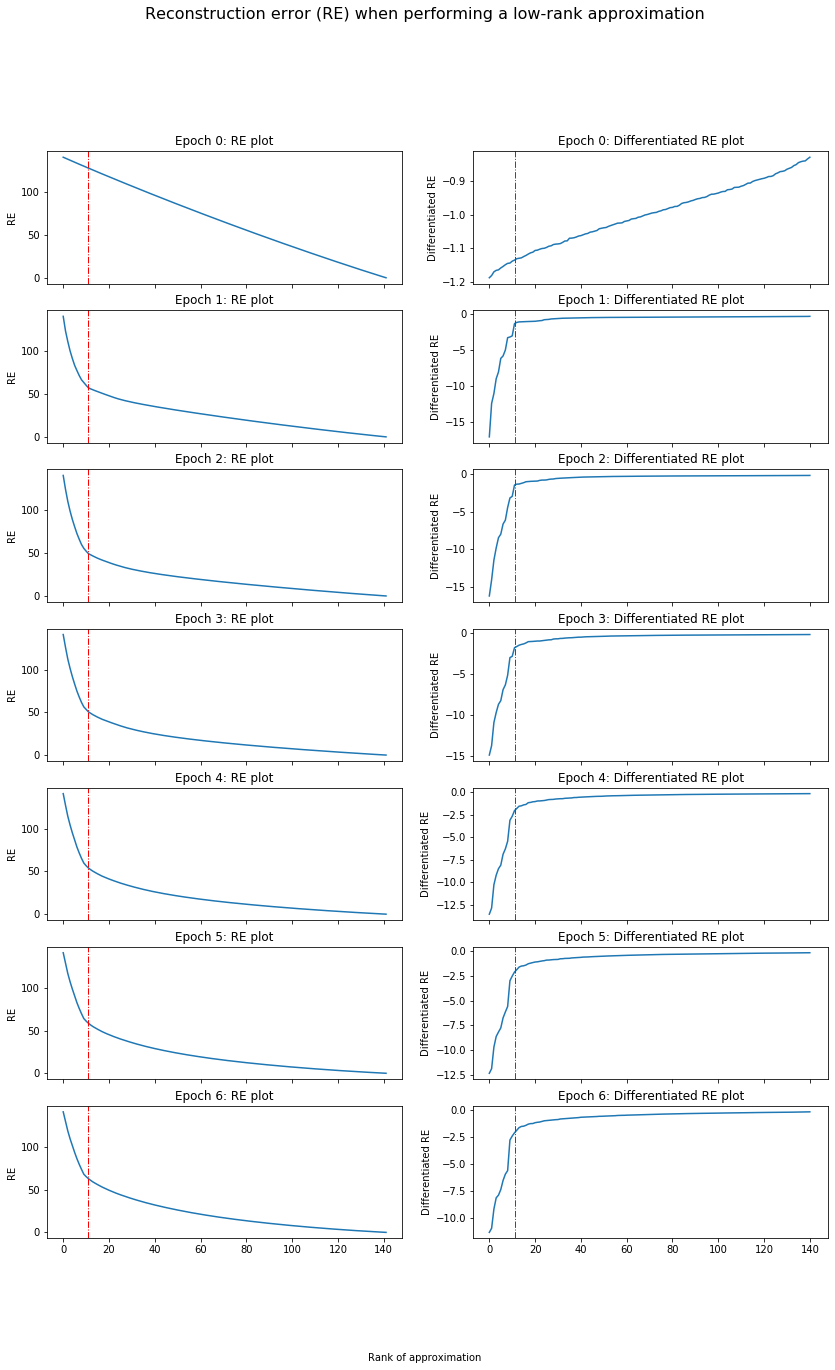

In [28]:
res = plot_reconstruction_error(s_selected)

In [29]:
def orthogonal_projection(A, b):
    X, residuals, _, _ = np.linalg.lstsq(A, b, rcond=None)
    projections = A @ X
    return X, residuals, projections

In [30]:
def compare_residuals(u, b1, b2, rank=10):
    _, residuals1, _ = orthogonal_projection(u[:, :rank], b1)
    _, residuals2, _ = orthogonal_projection(u[:, :rank], b2)

    fig, axs = plt.subplots(1, 2, sharey=True, figsize=(14, 6))
    axs[0].hist(residuals1, bins=50)
    axs[0].set_title("Selected weight vectors at initialization")
    axs[1].hist(residuals2, bins=50)
    axs[1].set_title("Unselected weight vectors at initialization")
    
    fig.suptitle("Residual distribution when projecting on low-rank approximation of trained subspace", fontsize=16)
    fig.text(0.5, 0.04, 'Residual', ha='center')
    fig.text(0.04, 0.5, 'Count', va='center', rotation='vertical')
    
    plt.show()

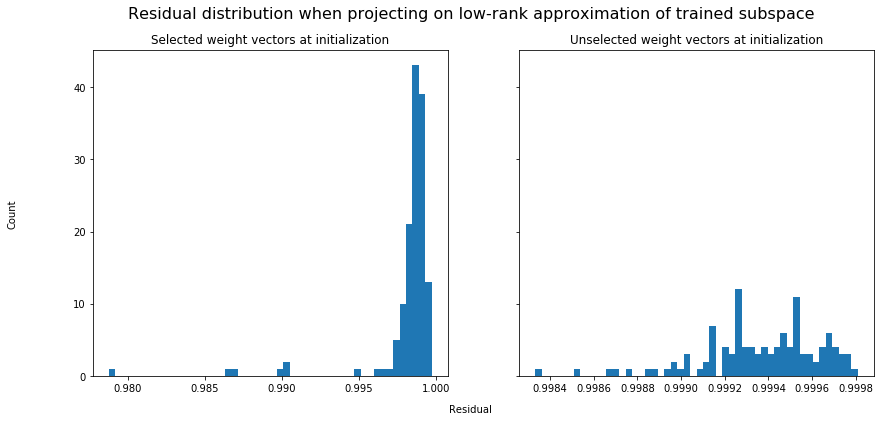

In [31]:
selected_b = w[0, selected_neurons, :].numpy().T
unselected_b = w[0, unselected_neurons, :].numpy().T
compare_residuals(u_selected[-1], selected_b, unselected_b, 10)

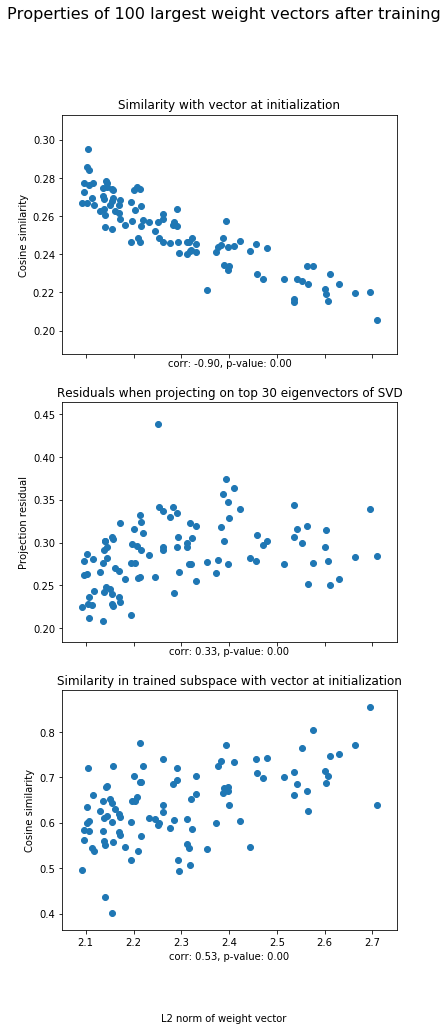

In [57]:
def top_weights_statistics(n_selected=50, rank=20):
    fig, axs = plt.subplots(3, 1, sharex=True, figsize=(6, 15))
    
    start = w[0].numpy().T
    end = w[-1].numpy().T
    indices = np.argsort(-weight_norms[-1])[:n_selected]
    x = weight_norms[-1][indices]
    
    similarity = np.diag(start.T @ end)
    y = similarity[indices]
    corr, p_value = pearsonr(x, y)
    axs[0].scatter(x, y)
    axs[0].set_title("Similarity with vector at initialization")
    axs[0].set_xlabel("corr: {:.2f}, p-value: {:.2f}".format(corr, p_value))
    axs[0].set_ylabel("Cosine similarity")
    
    _, _, projections1 = orthogonal_projection(u_selected[-1][:, :rank], start)
    _, residuals, projections2 = orthogonal_projection(u_selected[-1][:, :rank], end)
    y = residuals[indices]
    corr, p_value = pearsonr(x, y)
    axs[1].scatter(x, y)
    axs[1].set_title(f"Residuals when projecting on top {rank} eigenvectors of SVD")
    axs[1].set_xlabel("corr: {:.2f}, p-value: {:.2f}".format(corr, p_value))
    axs[1].set_ylabel("Projection residual")
    
    projections1 = projections1 / np.linalg.norm(projections1, axis=0)
    projections2 = projections2 / np.linalg.norm(projections2, axis=0)
    similarity = np.diag(projections1.T @ projections2)
    y = similarity[indices]
    corr, p_value = pearsonr(x, y)
    axs[2].scatter(x, y)
    axs[2].set_title("Similarity in trained subspace with vector at initialization")
    axs[2].set_xlabel("corr: {:.2f}, p-value: {:.2f}".format(corr, p_value))
    axs[2].set_ylabel("Cosine similarity")
    
    fig.suptitle(f"Properties of {n_selected} largest weight vectors after training", fontsize=16)
    fig.text(0.5, 0.04, 'L2 norm of weight vector', ha='center')
    plt.show()
    
top_weights_statistics(100, 30)

## Experiments

In [33]:
train_batch_size = 64
test_batch_size = 1000
trainloader, testloader, _ = get_cifar(train_batch_size, test_batch_size)
criterion = nn.CrossEntropyLoss()

Files already downloaded and verified
Files already downloaded and verified


In [34]:
accuracy = s.evaluate_model(testloader, criterion, 0)


Test set: Average loss: 2.3029, Accuracy:   1030/ 10000 (10%)



In [35]:
accuracy = s.evaluate_model(testloader, criterion, epochs-1)


Test set: Average loss: 0.9849, Accuracy:   7063/ 10000 (71%)



In [36]:
selected_model = s.sub_network(0, layer, unselected_neurons)

In [37]:
e = Experiment(selected_model, criterion, None, {})
accuracy, _ = e.test(testloader, [])


Test set: Average loss: 2.3011, Accuracy:   1062/ 10000 (11%)



In [38]:
unselected_model = s.sub_network(0, layer, selected_neurons)

In [39]:
e = Experiment(unselected_model, criterion, None, {})
accuracy, _ = e.test(testloader, [])


Test set: Average loss: 2.3048, Accuracy:   1079/ 10000 (11%)



In [40]:
selected_model = s.sub_network(epochs-1, layer, unselected_neurons)

In [41]:
e = Experiment(selected_model, criterion, None, {})
accuracy, _ = e.test(testloader, [])


Test set: Average loss: 0.9850, Accuracy:   7063/ 10000 (71%)



In [42]:
def projected_layer(experiment, layer, selection, u, s, vh, rank):
    new_experiment = experiment.clone()
    new_layer_weights = new_experiment.model.layer_weights(layer).numpy()
    approximation = np.dot(u[:, :rank] * s[:rank], vh[:rank]).T
    new_layer_weights[selection] = approximation
    new_experiment.model.set_weights(layer, new_layer_weights)
    return new_experiment

In [43]:
projected_e = projected_layer(e, layer, selected_neurons, u_selected[-1], s_selected[-1], vh_selected[-1], 20)
accuracy, _ = projected_e.test(testloader, [])


Test set: Average loss: 0.9434, Accuracy:   6791/ 10000 (68%)



### This result might be interesting!

In [44]:
unselected_model = s.sub_network(epochs-1, layer, selected_neurons)

In [45]:
e = Experiment(unselected_model, criterion, None, {})
accuracy, _ = e.test(testloader, [])


Test set: Average loss: 2.3082, Accuracy:   1000/ 10000 (10%)



In [46]:
selected_model = s.sub_network(epochs-1, layer, unselected_neurons)
new_layer_weights = selected_model.layer_weights(layer).numpy()
new_layer_weights[selected_neurons] = w[0, selected_neurons, :].numpy()
selected_model.set_weights(layer, new_layer_weights)

In [47]:
e = Experiment(selected_model, criterion, None, {})
accuracy, _ = e.test(testloader, [])


Test set: Average loss: 2.3251, Accuracy:   1153/ 10000 (12%)



## Model with resampled fc1 weights

In [48]:
new_output_dir = "out/Conv2-02_12_2019-12:09:41"
new_fp_paths, new_ip_paths, new_norms_paths = results_path(new_output_dir, layers)

In [49]:
new_acc_path = os.path.join(new_output_dir, common.METRICS_DIR, common.TRAINING_DIR, common.ACCURACY_FNAME)
new_test_accuracies = np.load(new_acc_path)
print("Best test accuracy at epoch N°", np.argmax(new_test_accuracies))

Best test accuracy at epoch N° 5


In [50]:
new_epochs = np.argmax(new_test_accuracies) + 1
new_weight_norms = np.load(new_norms_paths[layer])[:new_epochs]
new_s = Snapshots(new_output_dir)
new_weights = new_s.get_weights(layer)[:new_epochs]

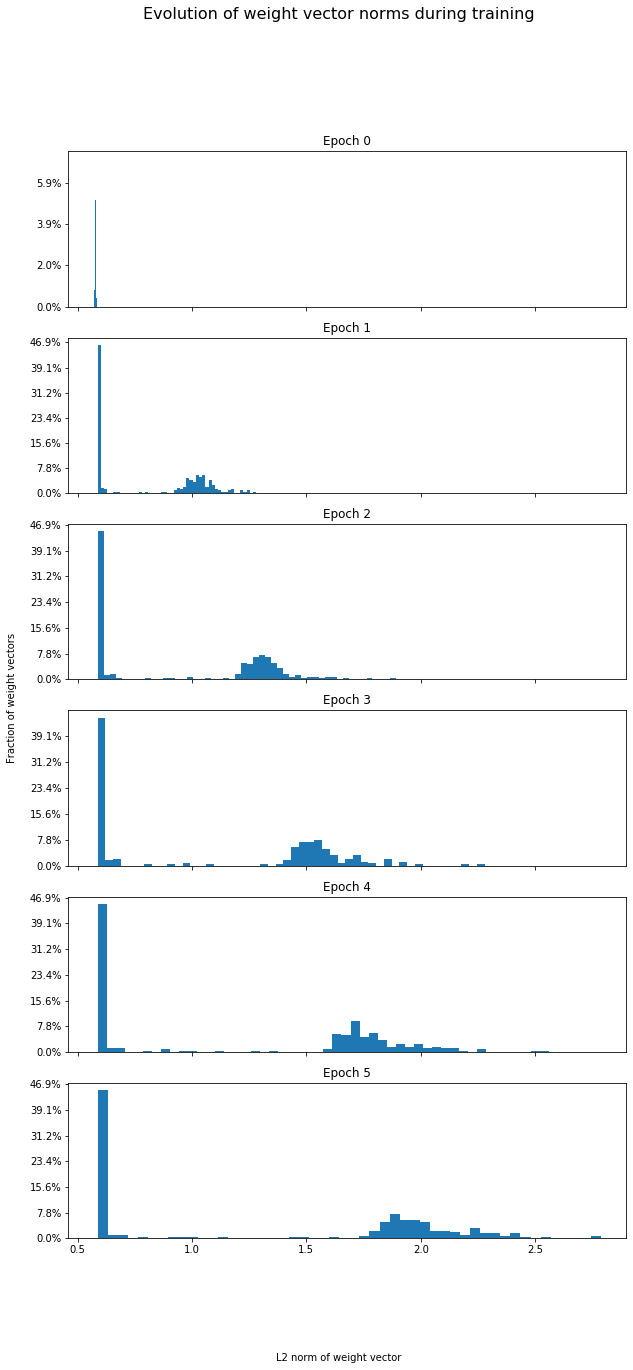

In [51]:
plot_training_norms(new_weight_norms)

In [52]:
new_w = torch.zeros(new_weights.shape)
# Normalize the weight vectors for every epoch
for epoch in range(new_epochs):
    new_w[epoch] = F.normalize(new_weights[epoch], p=2, dim=1)

In [53]:
new_trained_neurons = (new_weight_norms[-1] > cutoff)
new_selected_neurons = np.argwhere(new_trained_neurons).flatten().tolist()
new_unselected_neurons = np.argwhere(~new_trained_neurons).flatten().tolist()

In [54]:
new_u_selected, new_s_selected, new_vh_selected = svd(new_w[:, new_selected_neurons, :])
new_u_unselected, new_s_unselected, new_vh_unselected = svd(new_w[:, new_unselected_neurons, :])

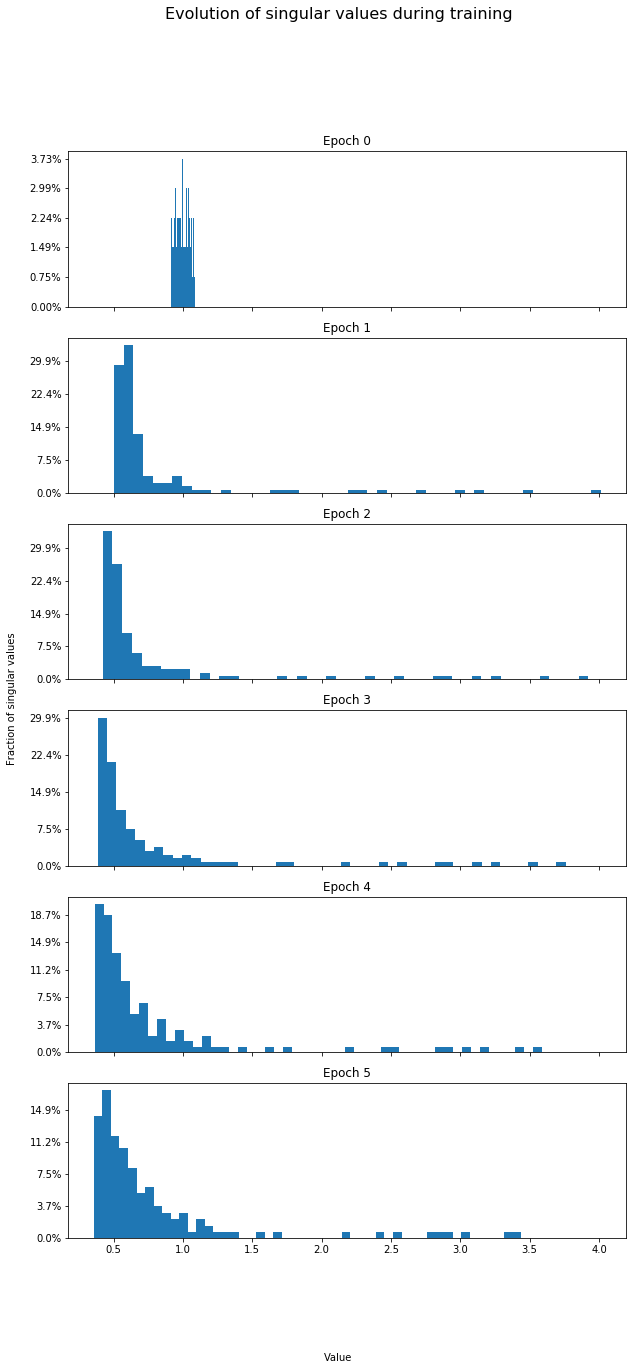

In [55]:
singular_value_distribution(new_s_selected)

In [56]:
np.rad2deg(subspace_angles(u_selected[-1][:, :10], new_u_selected[-1][:, :10]))

array([43.38398516, 37.79500058, 36.91770229, 36.14546101, 35.33766848,
       34.68498415, 34.1094793 , 33.70118662, 32.83849329, 31.1721847 ])